# Лабораторна робота No 7
## Сценарії обробки багатоспектральних супутникових зображень
### ФБ-21 Худоба Арсен

In [1]:
import sentinelhub 
import rasterio
from rasterio.plot import show
import numpy as np
import matplotlib
import os
from matplotlib import pyplot as plt
import sklearn.metrics
from pathlib import Path
import subprocess

1. Завантажити необхідні дані Sentinel-2 (або з Copernicus SciHub, або з Google-диска). За допомогою бібліотеки sentinelhub написати скрипт для
завантаження супутникових знімків Sentinel-2, які покривають Київ 
Список ідентифікаторів Sentinel-2:
– S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206 та
– S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206
Конкатенація каналів видимого, ближнього та середнього інфрачервоного спектральних діапазонів (канали 2, 3, 4 та 8) зображення в єдиний GEOTIFF файл.


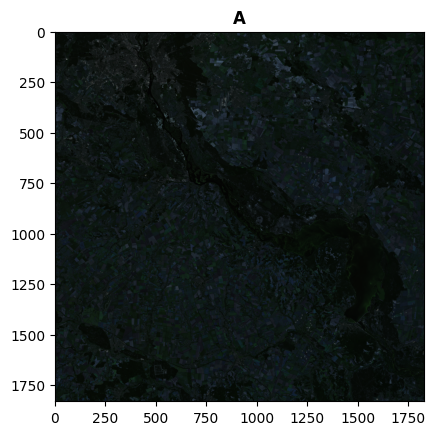

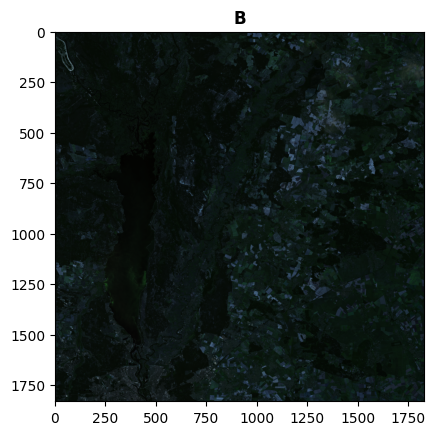

<Axes: title={'center': 'B'}>

In [2]:
def create_output_dir(directory):
    Path(directory).mkdir(parents=True, exist_ok=True)

def merge_bands(output_file, band_files):
    subprocess.run(['gdal_merge', '-o', output_file, '-separate'] + band_files, check=True)

def process_data(output_dir, band_files):
    create_output_dir(output_dir)
    output_file = Path(output_dir) / 'sentmerge.tif'
    merge_bands(str(output_file), band_files)
    return rasterio.open(output_file)

# Шляхи до файлів
BB02file = Path('SentData/BSentData/GRANULE/L2A_T36UUB_A021740_20190821T085815/IMG_DATA/R60m/T36UUB_20190821T085601_B02_60m.jp2')
BB03file = Path('SentData/BSentData/GRANULE/L2A_T36UUB_A021740_20190821T085815/IMG_DATA/R60m/T36UUB_20190821T085601_B03_60m.jp2')
BB04file = Path('SentData/BSentData/GRANULE/L2A_T36UUB_A021740_20190821T085815/IMG_DATA/R60m/T36UUB_20190821T085601_B04_60m.jp2')
BB8Afile = Path('SentData/BSentData/GRANULE/L2A_T36UUB_A021740_20190821T085815/IMG_DATA/R60m/T36UUB_20190821T085601_B8A_60m.jp2')

AB02file = Path('SentData/ASentData/GRANULE/L2A_T36UUA_A021740_20190821T085815/IMG_DATA/R60m/T36UUA_20190821T085601_B02_60m.jp2')
AB03file = Path('SentData/ASentData/GRANULE/L2A_T36UUA_A021740_20190821T085815/IMG_DATA/R60m/T36UUA_20190821T085601_B03_60m.jp2')
AB04file = Path('SentData/ASentData/GRANULE/L2A_T36UUA_A021740_20190821T085815/IMG_DATA/R60m/T36UUA_20190821T085601_B04_60m.jp2')
AB8Afile = Path('SentData/ASentData/GRANULE/L2A_T36UUA_A021740_20190821T085815/IMG_DATA/R60m/T36UUA_20190821T085601_B8A_60m.jp2')

# Обробка даних
rAsentmerge = process_data('Output/A', [AB02file, AB03file, AB04file, AB8Afile])
rBsentmerge = process_data('Output/B', [BB02file, BB03file, BB04file, BB8Afile])

# Відображення результатів
show(rAsentmerge.read([1, 2, 3]), adjust=True, title="A")
show(rBsentmerge.read([1, 2, 3]), adjust=True, title="B")

#### Перепроектування супутникового зображення у проєкцію 4326.

Creating output file that is 2209P x 1423L.
Processing Output\A\sentmerge.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 2222P x 1404L.
Processing Output\B\sentmerge.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


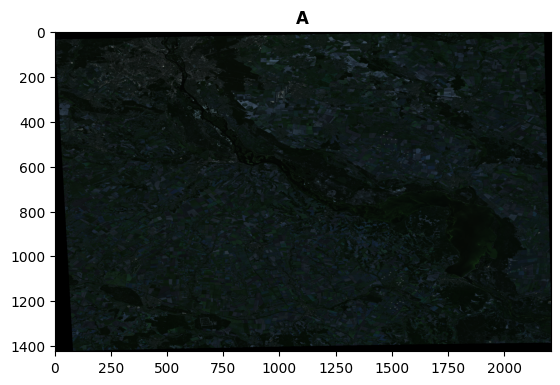

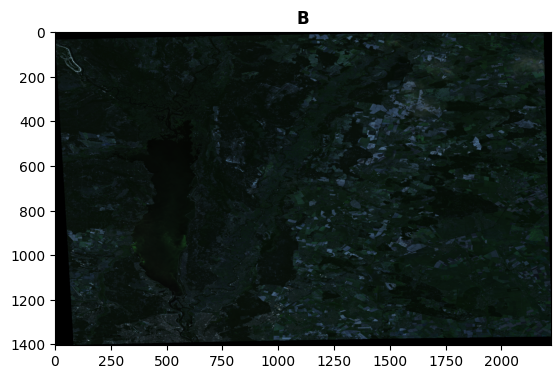

<Axes: title={'center': 'B'}>

In [3]:
def reproject_raster(input_path, output_path, target_srs):
    !gdalwarp -t_srs {target_srs} {input_path} {output_path}

reproject_raster('Output\\A\\sentmerge.tif', 'Output\\A\\Asent4326.tif', 'EPSG:4326')
reproject_raster('Output\\B\\sentmerge.tif', 'Output\\B\\Bsent4326.tif', 'EPSG:4326')

rAsent4326 = rasterio.open('Output\\A\\Asent4326.tif')
rBsent4326 = rasterio.open('Output\\B\\Bsent4326.tif')

show(rAsent4326.read([1, 2, 3]), adjust=True, title="A")
show(rBsent4326.read([1, 2, 3]), adjust=True, title="B")

#### Конкатенація всіх отриманих растрів у один 4-канальний файл TIFF.

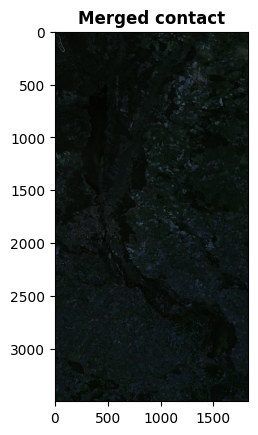

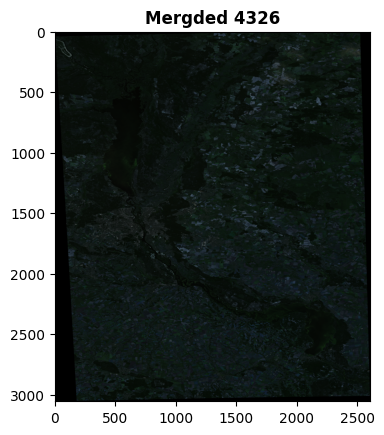

<Axes: title={'center': 'Mergded 4326'}>

In [4]:
def merge_rasters(input_paths, output_path):
    input_paths_str = [str(path) for path in input_paths]
    subprocess.run(['gdal_merge', '-o', str(output_path)] + input_paths_str, check=True)

def reproject_raster(input_path, output_path, target_srs):
    subprocess.run(['gdalwarp', '-t_srs', target_srs, str(input_path), str(output_path)], check=True)

# Шляхи до папок
A_path = Path('Output/A')
B_path = Path('Output/B')

# Об'єднання растрових зображень
merge_rasters([A_path / 'sentmerge.tif', B_path / 'sentmerge.tif'], 'Output/sentallmerge.tif')

# Перепроєктування
reproject_raster('Output/sentallmerge.tif', 'Output/sentall4326.tif', 'EPSG:4326')

# Відкриття та відображення результатів
rsentallmerge = rasterio.open('Output/sentallmerge.tif')
rsentall4326 = rasterio.open('Output/sentall4326.tif')

show(rsentallmerge.read([1, 2, 3]), adjust=True, title="Merged contact")
show(rsentall4326.read([1, 2, 3]), adjust=True, title="Mergded 4326")

#### Обріжте зображення за вашим векторним файлом використовуючи gdalwarp.

Creating output file that is 677P x 707L.
Processing Output\sentallmerge.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


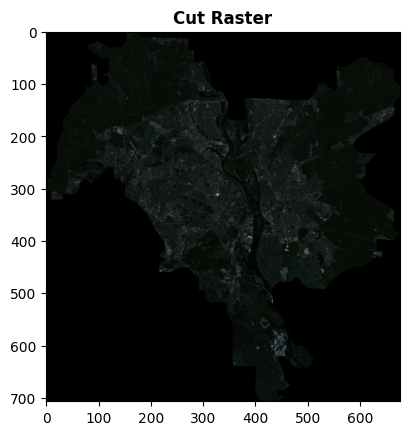

<Axes: title={'center': 'Cut Raster'}>

In [5]:
def crop_raster(input_path, output_path, cutline_path):
    !gdalwarp -cutline {cutline_path} -crop_to_cutline {input_path} {output_path}

input_path = 'Output\\sentallmerge.tif'
output_path = 'Output\\cutsent.tif'
cutline_path = 'Kyiv\\Kyiv_regions.shp'

crop_raster(input_path, output_path, cutline_path)

rcutsent = rasterio.open(output_path)

# Відображення обрізаного растра
show(rcutsent.read([1, 2, 3]), adjust=True, title="Cut Raster")

#### Конкатенація каналів видимого, ближнього та середнього інфрачервоного спектральних діапазонів (канали 2, 3, 4 та 8) зображення в єдиний GEOTIFF файл.

0...10...20...30...40...50...60...70...80...90...100 - done.


C:\ProgramData\anaconda3\envs\gdal\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


0...10...20...30...40...50...60...70...80...90...100 - done.


C:\ProgramData\anaconda3\envs\gdal\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


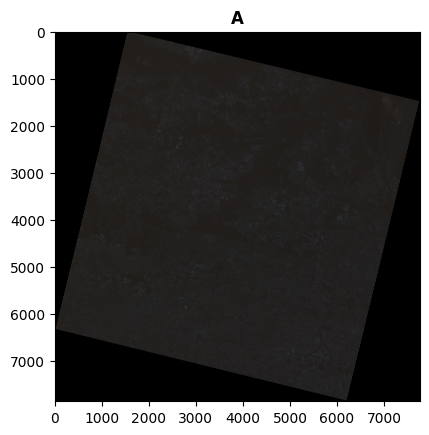

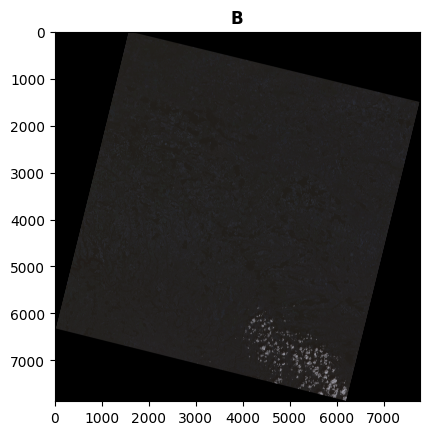

<Axes: title={'center': 'B'}>

In [6]:
AB2file = 'Landsat/LandA/LC08_L1TP_182025_20190830_20190903_01_T1_B2.TIF'
AB3file = 'Landsat/LandA/LC08_L1TP_182025_20190830_20190903_01_T1_B3.TIF'
AB4file = 'Landsat/LandA/LC08_L1TP_182025_20190830_20190903_01_T1_B4.TIF'
AB8file = 'Landsat/LandA/LC08_L1TP_182025_20190830_20190903_01_T1_B8.TIF'

BB2file = 'Landsat/LandB/LC08_L1TP_182026_20190830_20190903_01_T1_B2.TIF'
BB3file = 'Landsat/LandB/LC08_L1TP_182026_20190830_20190903_01_T1_B3.TIF'
BB4file = 'Landsat/LandB/LC08_L1TP_182026_20190830_20190903_01_T1_B4.TIF'
BB8file = 'Landsat/LandB/LC08_L1TP_182026_20190830_20190903_01_T1_B8.TIF'

# Створення папок, якщо вони не існують
os.makedirs('OUTLandsat/LandsatA', exist_ok=True)
os.makedirs('OUTLandsat/LandsatB', exist_ok=True)

# Об'єднання растрових файлів
!gdal_merge -o OUTLandsat/LandsatA/Alandmerge.tif -separate {AB2file} {AB3file} {AB4file} {AB8file}
!gdal_merge -o OUTLandsat/LandsatB/Blandmerge.tif -separate {BB2file} {BB3file} {BB4file} {BB8file}

# Відкриття об'єднаних растрів
rAlandmerge = rasterio.open('OUTLandsat/LandsatA/Alandmerge.tif')
rBlandmerge = rasterio.open('OUTLandsat/LandsatB/Blandmerge.tif')

# Відображення растрів зі зміненою кольоровою гамою на сіру
show(rAlandmerge.read([1,2,3]), adjust=True, title="A")
show(rBlandmerge.read([1,2,3]), adjust=True, title="B")

#### Перепроектування супутникового зображення у проєкцію 4326.

Creating output file that is 9476P x 6325L.
Processing OUTLandsat/LandsatB/Blandmerge.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 9665P x 6264L.
Processing OUTLandsat/LandsatA/Alandmerge.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


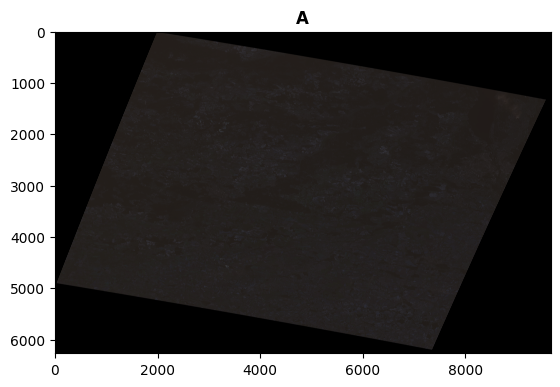

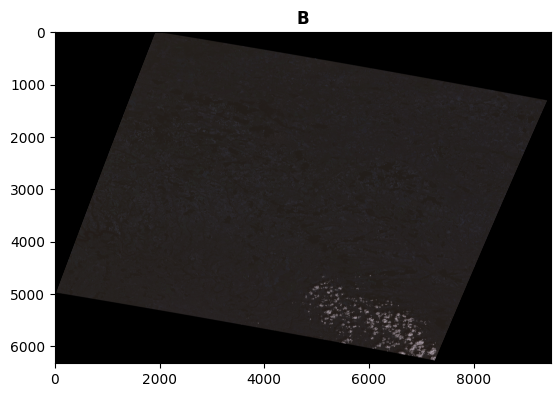

<Axes: title={'center': 'B'}>

In [7]:
# Шляхи до растрових файлів
AB2file = 'OUTLandsat/LandsatA/Alandmerge.tif'
AB3file = 'OUTLandsat/LandsatA/Alandmerge.tif'
AB4file = 'OUTLandsat/LandsatA/Alandmerge.tif'
AB8file = 'OUTLandsat/LandsatA/Alandmerge.tif'

BB2file = 'OUTLandsat/LandsatB/Blandmerge.tif'
BB3file = 'OUTLandsat/LandsatB/Blandmerge.tif'
BB4file = 'OUTLandsat/LandsatB/Blandmerge.tif'
BB8file = 'OUTLandsat/LandsatB/Blandmerge.tif'

# Перепроектування супутникових зображень у проєкцію 4326
!gdalwarp -t_srs EPSG:4326 {BB2file} OUTLandsat/LandsatB/Bland4326.tif
!gdalwarp -t_srs EPSG:4326 {AB2file} OUTLandsat/LandsatA/Aland4326.tif

# Відкриття перепроектованих растрів
rBland4326 = rasterio.open('OUTLandsat/LandsatB/Bland4326.tif')
rAland4326 = rasterio.open('OUTLandsat/LandsatA/Aland4326.tif')

# Відображення перепроектованих растрів
show(rAland4326.read([1,2,3]), adjust=True, title="A")
show(rBland4326.read([1,2,3]), adjust=True, title="B")


#### Конкатенація всіх отриманих растрів у один 4-канальний файл TIFF.

0...10...20...30...40...50...60...70...80...90...100 - done.


C:\ProgramData\anaconda3\envs\gdal\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


0...10...20...30...40...50...60...70...80...90...100 - done.


C:\ProgramData\anaconda3\envs\gdal\Lib\site-packages\osgeo\gdal.py:312: FutureWarning: Neither gdal.UseExceptions() nor gdal.DontUseExceptions() has been explicitly called. In GDAL 4.0, exceptions will be enabled by default.
  warnings.warn(


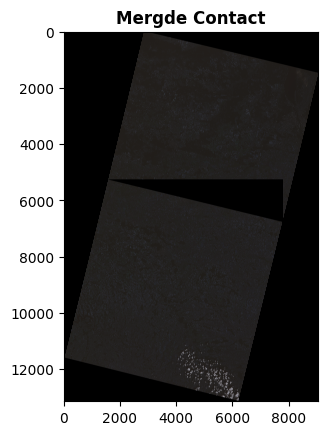

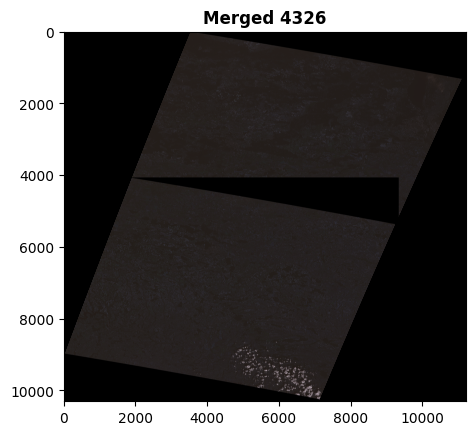

<Axes: title={'center': 'Merged 4326'}>

In [8]:
!gdal_merge -o OUTLandsat\\landallmerge.tif OUTLandsat\\LandsatA\\Alandmerge.tif OUTLandsat\\LandsatB\\Blandmerge.tif 
!gdal_merge -o OUTLandsat\\landall4326.tif OUTLandsat\\LandsatA\\Aland4326.tif OUTLandsat\\LandsatB\\Bland4326.tif 

rlandallmerge=rasterio.open('OUTLandsat\\landallmerge.tif')
rlandall4326=rasterio.open('OUTLandsat\\landall4326.tif')

show(rlandallmerge.read([1,2,3]),adjust=True, title="Mergde Contact")
show(rlandall4326.read([1,2,3]),adjust=True, title="Merged 4326")


#### Обріжте зображення за вашим векторним файлом використовуючи gdalwarp.

Creating output file that is 1365P x 1370L.
Processing OUTLandsat\landallmerge.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 1647P x 1081L.
Processing OUTLandsat\landall4326.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.


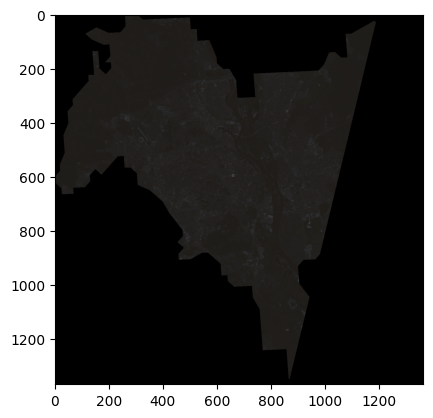

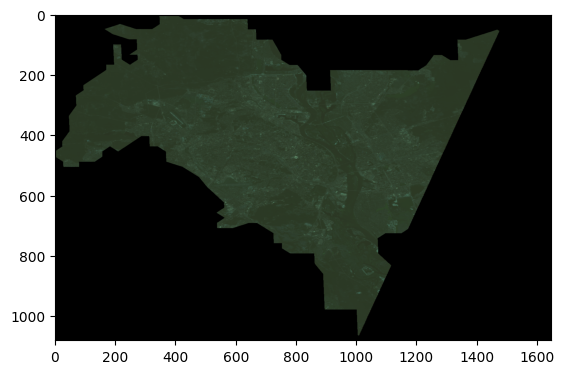

<Axes: >

In [9]:
!gdalwarp -cutline Kyiv/Kyiv_regions.shp -crop_to_cutline OUTLandsat\landallmerge.tif OUTLandsat\landcutmerge.tif
!gdalwarp -cutline Kyiv/Kyiv_regions.shp -crop_to_cutline OUTLandsat\landall4326.tif OUTLandsat\landcut4326.tif


rlandcutmerge=rasterio.open('OUTLandsat\\landcutmerge.tif')
rlandcut4326=rasterio.open('OUTLandsat\\landcut4326.tif')
show(rlandcutmerge.read([1,2,3]),adjust=True)
show(rlandcut4326.read([1,2,3]),adjust=True)

#### Переведіть панхроматичний канал у 30 м, а RGB канали у 60 метрів.

In [10]:
!mkdir OUTLandsat\Pansharpen
!gdal_translate -tr 60 60 OUTLandsat\LandsatA\Alandmerge.tif OUTLandsat\Pansharpen\landrgb60.tif
!gdal_translate -tr 30 30 Landsat\LandA\LC08_L1TP_182025_20190830_20190903_01_T1_B8.tif OUTLandsat\Pansharpen\landp30.tif

Input file size is 7761, 7861
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 15521, 15721
0...10...20...30...40...50...60...70...80...90...100 - done.


#### Після цього паншарпніть 60 метровий RGB за допомогою 30 м панхроматичного каналу.

In [11]:
pansharpen_methods = ['nearest', 'bilinear', 'cubic', 'cubicspline', 'lanczos', 'average']

pansharpen_output_folder = 'OUTLandsat\\Pansharpen'
pansharpen_input_p30 = 'OUTLandsat\\Pansharpen\\landp30.tif'
pansharpen_input_rgb60 = 'OUTLandsat\\Pansharpen\\landrgb60.tif'

for method in pansharpen_methods:
    output_path = os.path.join(pansharpen_output_folder, f'landpar{method.upper()}.tif')
    cmd = f"gdal_pansharpen -r {method} {pansharpen_input_p30} {pansharpen_input_rgb60} {output_path}"
    os.system(cmd)

#### Підрахуйте метрики точності паншарпенінгу

In [12]:
# відкриття результатів паншарпенінгу
pansharpen_methods = {
    'average': rasterio.open('OUTLandsat/Pansharpen/landparAVERAGE.tif').read().flatten(),
    'nearest': rasterio.open('OUTLandsat/Pansharpen/landparNEAREST.tif').read().flatten(),
    'bilinear': rasterio.open('OUTLandsat/Pansharpen/landparBILINEAR.tif').read().flatten(),
    'cubic': rasterio.open('OUTLandsat/Pansharpen/landparCUBIC.tif').read().flatten(),
    'cubicspline': rasterio.open('OUTLandsat/Pansharpen/landparCUBICSPLINE.tif').read().flatten(),
    'lanczos': rasterio.open('OUTLandsat/Pansharpen/landparLANCZOS.tif').read().flatten()
}

# відкриття вихідного файлу для порівняння
reference = rasterio.open('OUTLandsat/LandsatA/Alandmerge.tif').read().flatten()

# коефіцієнти детермінації (R^2) для кожного методу паншарпенінгу
similarity_scores = {
    method: sklearn.metrics.r2_score(reference, data)
    for method, data in pansharpen_methods.items()
}

# Виведення результатів
print("Коефіцієнти детермінації (R^2) для кожного методу паншарпенінгу:")
for method, score in similarity_scores.items():
    print(f"{method.capitalize():12}: {score}")

Коефіцієнти детермінації (R^2) для кожного методу паншарпенінгу:
Average     : 0.991102998471593
Nearest     : 0.9900882662638926
Bilinear    : 0.9918845353446165
Cubic       : 0.9916183578382163
Cubicspline : 0.9929935539401706
Lanczos     : 0.9917826442591202


In [13]:
def get_best_pansharpening_method(similarity_scores):
    best_method = max(similarity_scores, key=similarity_scores.get)
    best_score = similarity_scores[best_method]
    return best_method, best_score

# Виклик функції та виведення результатів
best_method, best_score = get_best_pansharpening_method(similarity_scores)
print(f"Найкращий метод паншарпенінгу: {best_method.capitalize()}")
print(f"Коефіцієнт детермінації (R^2): {best_score}")

Найкращий метод паншарпенінгу: Cubicspline
Коефіцієнт детермінації (R^2): 0.9929935539401706
